In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load Data

In [2]:
df_songs = pd.read_csv('Data/song_genre_data.csv')
df_users = pd.read_csv('Data/user_data.csv')
df_song_user = pd.read_csv('Data/song_user.csv')

# Data Cleaning

In [59]:
df_songs_clustering = df_song_user.drop_duplicates(subset=['song_id']).reset_index(drop=True)
df_songs_clustering = df_songs_clustering.drop(columns=['user_id', 'play_count'])
df_songs_clustering.shape

(3675, 18)

In [60]:
df_songs_clustering.isnull().sum()

song_id                 0
track_id                0
artist_id               0
song_title              0
artist_name             0
release                 0
artist_terms            0
artist_terms_freq       0
song_hotness          698
tempo                   0
loudness                0
duration                0
danceability            0
energy                  0
key                     0
mode                    0
year                    0
genre                1309
dtype: int64

In [8]:
# List of numerical and categorical columns with nan values
numerical_cols = ['song_hotness']
categorical_cols = ['genre']

# Fill NaNs in numerical columns with mean
for col in numerical_cols:
    df_songs_clustering[col].fillna(df_songs_clustering[col].mean(), inplace=True)

# Fill NaNs in categorical columns with mode
for col in categorical_cols:
    df_songs_clustering[col].fillna(df_songs_clustering[col].mode()[0], inplace=True)

In [61]:
clustering_features = ['tempo','loudness','duration','danceability','energy','key','mode']
df_clustering = df_songs_clustering[clustering_features]

In [30]:
# encoder = OneHotEncoder(sparse=False)
# # Fit and transform the 'genre' column
# encoded_genre = encoder.fit_transform(df_clustering[['genre']])
# encoded_genre_df = pd.DataFrame(encoded_genre, columns=encoder.get_feature_names_out(['genre']))

# # Concatenate the encoded genre DataFrame with the original DataFrame
# df_clustering = pd.concat([df_clustering.drop('genre', axis=1), encoded_genre_df], axis=1)

In [62]:
# Scale the features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clustering), columns=df_clustering.columns)


In [63]:
df_scaled.shape

(3675, 7)

# KMeans Clustering

## PCA

In [65]:
pca = PCA(n_components=df_scaled.shape[1], random_state=42)
principalComponents = pca.fit_transform(df_scaled)

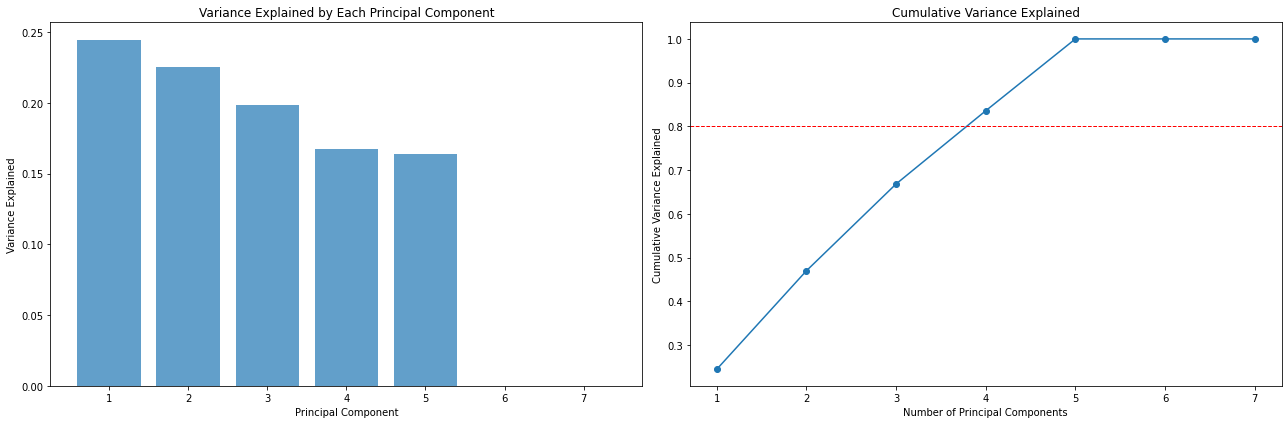

In [66]:
# Calculate explained variance and cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Variance explained plot
axs[0].bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
axs[0].set_title('Variance Explained by Each Principal Component')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Variance Explained')

# Cumulative variance explained plot
axs[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
axs[1].set_title('Cumulative Variance Explained')
axs[1].set_xlabel('Number of Principal Components')
axs[1].set_ylabel('Cumulative Variance Explained')

axs[1].axhline(y=0.8, color='r', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

In [67]:
num_pca = 4
df_pca = pd.DataFrame(principalComponents[:, :num_pca], columns=[f'PC{i+1}' for i in range(num_pca)])

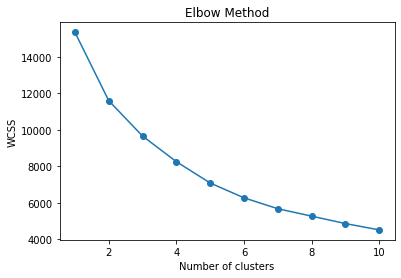

In [68]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [69]:
silhouette_scores = []
davies_bouldin_indices = []

for i in range(2, 11):  
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(df_pca)
    
    silhouette_scores.append(silhouette_score(df_pca, cluster_labels))
    davies_bouldin_indices.append(davies_bouldin_score(df_pca, cluster_labels))

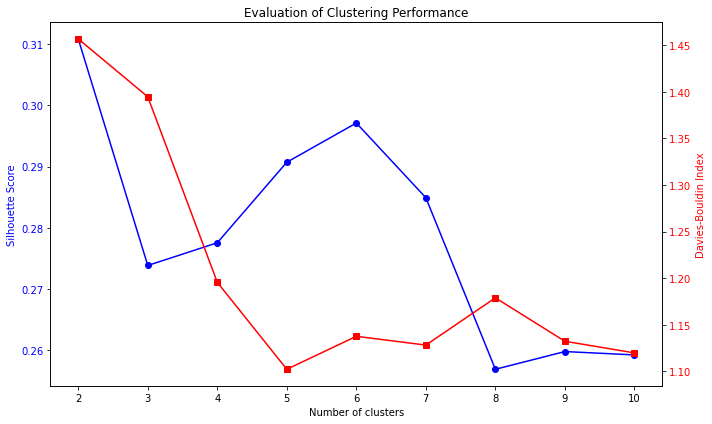

In [70]:
# Plotting silhouette score and Davies-Bouldin index side by side
fig, ax1 = plt.subplots(figsize=(10, 6))

# Silhouette Score plot
ax1.plot(range(2, 11), silhouette_scores, marker='o', color='b', label='Silhouette Score')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Evaluation of Clustering Performance')

# Davies-Bouldin Index plot on the same axis
ax2 = ax1.twinx()
ax2.plot(range(2, 11), davies_bouldin_indices, marker='s', color='r', label='Davies-Bouldin Index')
ax2.set_ylabel('Davies-Bouldin Index', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Legends
fig.tight_layout()
plt.show()

In [71]:
optimal_k = 6 # Replace with the number determined from the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(df_pca)

In [72]:
df_pca['cluster'].value_counts()

4    1100
1     904
5     583
0     496
2     463
3     129
Name: cluster, dtype: int64

In [75]:
# cluster_analysis = df_pca.groupby('cluster').mean()
# print(cluster_analysis)


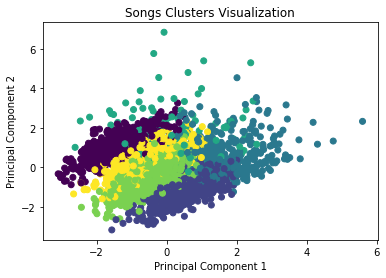

In [46]:
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['cluster'])
plt.title('Songs Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


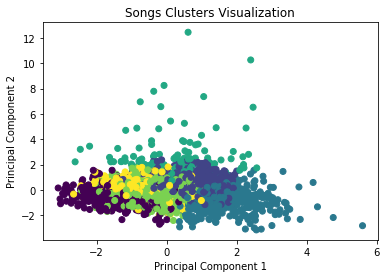

In [47]:
plt.scatter(df_pca['PC1'], df_pca['PC3'], c=df_pca['cluster'])
plt.title('Songs Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

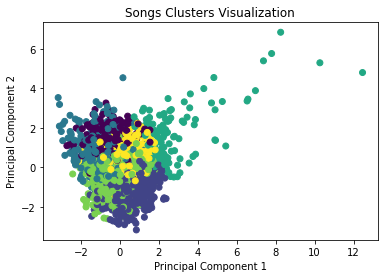

In [48]:
plt.scatter(df_pca['PC3'], df_pca['PC2'], c=df_pca['cluster'])
plt.title('Songs Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

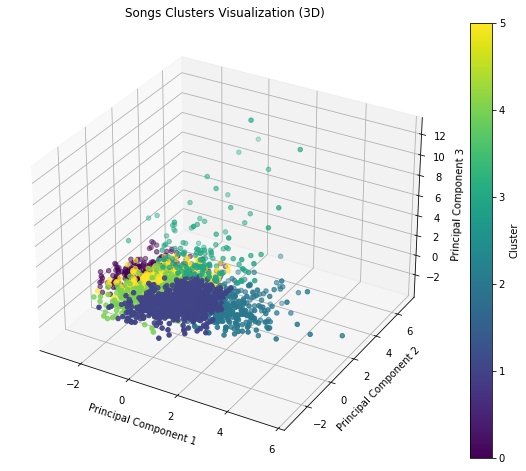

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming df_pca has columns 'PC1', 'PC2', 'PC3' and 'cluster' representing cluster labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter plot
sc = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=df_pca['cluster'], cmap='viridis')
plt.colorbar(sc, ax=ax, label='Cluster')  # Optional color bar to indicate cluster colors

# Plot labels
ax.set_title('Songs Clusters Visualization (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()


# Autoencoder

In [1]:
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
data = scaler.fit_transform(df_clustering)
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

class SongDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = SongDataset(train_data)
val_dataset = SongDataset(val_data)

NameError: name 'StandardScaler' is not defined

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Use Sigmoid if input features are scaled between 0 and 1
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


In [ ]:
input_dim = train_data.shape[1]  # Number of features
latent_dim = 10  # Adjust as needed

model = Autoencoder(input_dim, latent_dim)

In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training Parameters
num_epochs = 50

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        
        # Forward pass
        outputs = model(batch)
        loss = criterion(outputs, batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch.size(0)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            outputs = model(batch)
            loss = criterion(outputs, batch)
            val_loss += loss.item() * batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch [1/50], Train Loss: 1.0937, Val Loss: 0.7763
Epoch [2/50], Train Loss: 0.9815, Val Loss: 0.7739
Epoch [3/50], Train Loss: 0.9733, Val Loss: 0.7598
Epoch [4/50], Train Loss: 0.9634, Val Loss: 0.7532
Epoch [5/50], Train Loss: 0.9589, Val Loss: 0.7502
Epoch [6/50], Train Loss: 0.9554, Val Loss: 0.7433
Epoch [7/50], Train Loss: 0.9472, Val Loss: 0.7363
Epoch [8/50], Train Loss: 0.9441, Val Loss: 0.7350
Epoch [9/50], Train Loss: 0.9429, Val Loss: 0.7333
Epoch [10/50], Train Loss: 0.9386, Val Loss: 0.7265
Epoch [11/50], Train Loss: 0.9327, Val Loss: 0.7216
Epoch [12/50], Train Loss: 0.9249, Val Loss: 0.7165
Epoch [13/50], Train Loss: 0.9229, Val Loss: 0.7159
Epoch [14/50], Train Loss: 0.9225, Val Loss: 0.7156
Epoch [15/50], Train Loss: 0.9222, Val Loss: 0.7156
Epoch [16/50], Train Loss: 0.9221, Val Loss: 0.7158
Epoch [17/50], Train Loss: 0.9221, Val Loss: 0.7155
Epoch [18/50], Train Loss: 0.9220, Val Loss: 0.7154
Epoch [19/50], Train Loss: 0.9219, Val Loss: 0.7154
Epoch [20/50], Train 

In [ ]:
# Set model to evaluation mode
model.eval()

# Concatenate all data for encoding
full_data = torch.from_numpy(data).float().to(device)

with torch.no_grad():
    latent_representations = model.encoder(full_data).cpu().numpy()

print(f'Latent Representations Shape: {latent_representations.shape}')


Latent Representations Shape: (3675, 10)


In [ ]:
# Initialize PCA to reduce latent_dim to 2 components
pca = PCA(n_components=2, random_state=42)
latent_pca = pca.fit_transform(latent_representations)

# Add PCA components to the DataFrame
df_clustering['PC1'] = latent_pca[:, 0]
df_clustering['PC2'] = latent_pca[:, 1]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


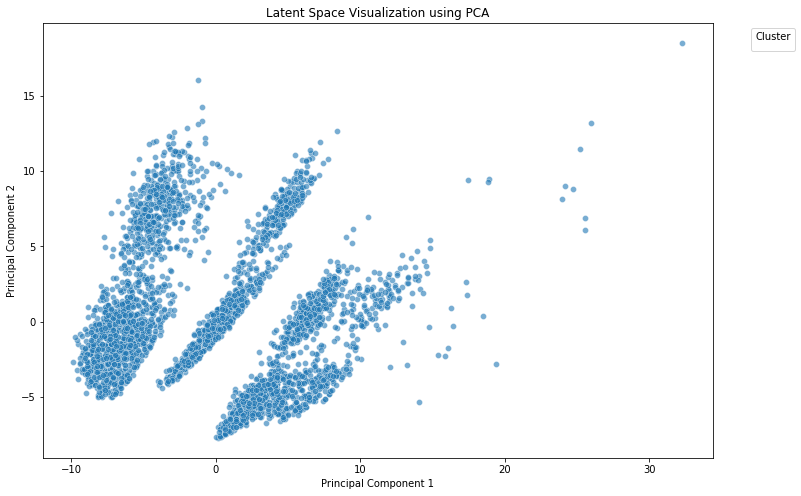

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    data=df_clustering,
    legend='full',
    alpha=0.6
)
plt.title('Latent Space Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
def recommend_songs(song_id, num_recommendations=5):
    # Find the cluster for the given song
    song_cluster = songs_df.loc[songs_df['song_id'] == song_id, 'cluster'].values[0]
    # Get other songs from the same cluster
    similar_songs = songs_df[songs_df['cluster'] == song_cluster]
    # Exclude the input song
    similar_songs = similar_songs[similar_songs['song_id'] != song_id]
    # Return top N recommendations
    return similar_songs.sample(num_recommendations)

# Example usage
recommendations = recommend_songs(song_id='SOME_SONG_ID')
print(recommendations)


In [ ]:
df = df_song_user.copy()

# Make recommender system 

In [73]:
df_songs_clustering['cluster'] = df_pca['cluster'].values

In [79]:
df_songs_clustering.head(2)

,song_id,track_id,artist_id,song_title,artist_name,release,artist_terms,artist_terms_freq,song_hotness,tempo,loudness,duration,danceability,energy,key,mode,year,genre,cluster
0,SOWEZSI12A81C21CE6,TRAUCNU128F42671EB,AR2UQQ51187B9AC816,Tu Quieres Volver,Gipsy Kings,Greatest Hits,"['flamenco', 'soundtrack', 'folk', 'spanish', ...","[0.9085998342694063, 1.0, 0.974313019239368, 0...",0.778821,165.006,-8.403,194.87302,0.0,0.0,5,0,1987,NaN,5
1,SODCXXY12AB0187452,TRBFXMJ12903CB50F6,ARXLMH011C8A415658,Freaxxx,brokeNCYDE,BC 13-EP,"['pop rap', 'crunk', 'rapcore', 'screamo', 'br...","[1.0, 0.9259412500081688, 0.9259412500081688, ...",0.682113,119.612,-11.588,214.98730,0.0,0.0,1,1,2008,NaN,1


In [78]:
df_song_user.head(2)

,user_id,song_id,play_count,track_id,artist_id,song_title,artist_name,release,artist_terms,artist_terms_freq,song_hotness,tempo,loudness,duration,danceability,energy,key,mode,year,genre
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOWEZSI12A81C21CE6,1,TRAUCNU128F42671EB,AR2UQQ51187B9AC816,Tu Quieres Volver,Gipsy Kings,Greatest Hits,"['flamenco', 'soundtrack', 'folk', 'spanish', ...","[0.9085998342694063, 1.0, 0.974313019239368, 0...",0.778821,165.006,-8.403,194.87302,0.0,0.0,5,0,1987,NaN
1,833c530ecda3d99deb8395f70400aa3999783d91,SOWEZSI12A81C21CE6,2,TRAUCNU128F42671EB,AR2UQQ51187B9AC816,Tu Quieres Volver,Gipsy Kings,Greatest Hits,"['flamenco', 'soundtrack', 'folk', 'spanish', ...","[0.9085998342694063, 1.0, 0.974313019239368, 0...",0.778821,165.006,-8.403,194.87302,0.0,0.0,5,0,1987,NaN


In [85]:
def recommend_songs(user_id, song_id, df_songs, df_user_songs, num_recommendations=5):
    # Check if the song_id exists
    if song_id not in df_songs['song_id'].values:
        return [None] * num_recommendations  # Return placeholders if song_id is not found
    
    # Get the cluster of the given song
    song_cluster = df_songs.loc[df_songs['song_id'] == song_id, 'cluster'].values[0]
    
    # Get all songs in the same cluster
    cluster_songs = df_songs[df_songs['cluster'] == song_cluster]['song_id'].tolist()
    
    # Get all songs the user has already interacted with
    user_songs = df_user_songs[df_user_songs['user_id'] == user_id]['song_id'].tolist()
    
    # Exclude songs the user has already interacted with
    recommended_songs = list(set(cluster_songs) - set(user_songs))
    
    # Limit to the desired number of recommendations, adding None if fewer than required
    recommended_songs = (recommended_songs + [None] * num_recommendations)[:num_recommendations]
    
    return recommended_songs

# Create an empty list to store the results
recommendations_list = []

# Iterate through each row in df_user_songs to get recommendations
for index, row in df_song_user[:1].iterrows():
    user_id = row['user_id']
    song_id = row['song_id']
    
    # Get the recommendations
    recommendations = recommend_songs(user_id, song_id, df_songs_clustering, df_song_user)
    
    # Append the user_id, song_id, and recommendations to the list
    recommendations_list.append([user_id, song_id] + recommendations)

df_recommendations = pd.DataFrame(recommendations_list, columns=[
    'user_id', 'song_id', 'recommendation 1', 'recommendation 2', 
    'recommendation 3', 'recommendation 4', 'recommendation 5'
])

In [86]:
df_recommendations

,user_id,song_id,recommendation 1,recommendation 2,recommendation 3,recommendation 4,recommendation 5
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOWEZSI12A81C21CE6,SOQXAGF12A58A7BB46,SORNYFV12AF729F4A0,SOVBLDE12AB017F8AF,SOHCZTI12A8C139141,SODYZLC12A6D4F7BD3


In [ ]:
def precision_at_k(user_id, recommended_songs, user_interactions, k=5):
    # Get songs the user has actually interacted with
    actual_songs = user_interactions[user_interactions['user_id'] == user_id]['song_id'].tolist()
    
    # Count the number of recommendations that are in actual songs
    relevant_recommendations = len([song for song in recommended_songs[:k] if song in actual_songs])
    
    # Calculate precision at K
    precision = relevant_recommendations / k
    return precision


In [ ]:
# For demonstration, assuming df_user_songs has historical interactions for each user
precisions = []
for index, row in df_user_songs.iterrows():
    user_id = row['user_id']
    song_id = row['song_id']
    
    # Get recommendations for the user and song
    recommendations = recommend_songs(user_id, song_id, df_songs, df_user_songs)
    
    # Compute Precision@5
    precision = precision_at_k(user_id, recommendations, df_user_songs, k=5)
    precisions.append(precision)

# Calculate the average precision across all users
average_precision = sum(precisions) / len(precisions)
print(f"Average Precision@5: {average_precision}")
